In [5]:
from typing import List
import nltk
import os
import numpy as np
import pandas as pd
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from enchant.checker import SpellChecker
# from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
import swifter
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

## Non dynamic learning rate 

In [6]:
import tensorflow.compat.v1 as tf
import numpy as np
from typing import List
import math

tf.disable_v2_behavior()
eps = 0.2 #1e-2

def save_loss(data: list, filename: str):
    with open(filename, 'w') as f:
        for item in data:
            f.write("%s\n" % item)


class LogisticRegression:
    def __init__(self, X_train: np.ndarray, y_train: np.ndarray, x_validation:np.ndarray, y_validation: np.ndarray, epoch=1000, learning_rate=0.0001, batch_size=200):
        """
        weighted logistic regression using cross entropy loss function
        :param num_iter:
        :param batch_size: -1 means all
        """
        self.losses = []
        self.valid_loss = []
        self.sess = tf.Session()
        features = X_train.shape[1]
        self.x = tf.placeholder(tf.float64, [None, features])
        y_train_variable = tf.placeholder(tf.float64, [None, 1])
        W = tf.Variable(tf.random.uniform([features, 1],dtype=tf.float64))
        b = tf.Variable(tf.random.uniform([1],dtype=tf.float64))
        self.y = tf.add(tf.matmul(self.x, W), b)
        w1_weight = (y_train == 1).sum()    # for imbalance data
        w0_weight = (y_train == 0).sum()
        # pos_weight multiple the 1 label => targets * -log(sigmoid(logits)) * pos_weight 
        loss = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(labels= y_train_variable, 
            logits= tf.cast(self.y, tf.float64), pos_weight=tf.constant((w1_weight+w0_weight)/w1_weight, tf.float64)))
        update = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss) 
        self.sess.run(tf.global_variables_initializer())
        rows_num = X_train.shape[0]
        for i in range(0, epoch):
            for counter_step in range(0, rows_num//batch_size):
                X_batch = X_train[counter_step * batch_size:min((counter_step + 1) * batch_size, rows_num)]
                Y_batch = y_train[counter_step * batch_size:min((counter_step + 1) * batch_size, rows_num)]
                Y_batch = Y_batch.reshape((Y_batch.size, 1))
                self.sess.run(update, feed_dict={self.x: X_batch, y_train_variable: Y_batch})
            loss_value = self.sess.run(loss, feed_dict={self.x: X_batch, y_train_variable: Y_batch})
            loss_value_validation = self.sess.run(loss, feed_dict={self.x:x_validation, y_train_variable: y_validation.reshape(y_validation.size,1)})
            print(f"iteration {i}: loss value is: {loss_value}")
            self.losses.append(loss_value)
            self.valid_loss.append(loss_value_validation)
        save_loss(self.losses, filename="train_error.txt")
        save_loss(self.valid_loss, filename="validation_error.txt")

    def predict(self, X_test, thr=0.4):
        predictions = self.sess.run(self.y, feed_dict={self.x: X_test})
        predictions[predictions >= thr] = 1
        predictions[predictions < thr] = 0
        return predictions


## dynamic learning rate

In [7]:
import tensorflow.compat.v1 as tf
import numpy as np
from typing import List
import math

tf.disable_v2_behavior()
eps = 0.2 #1e-2

def save_loss(data: list, filename: str):
    with open(filename, 'w') as f:
        for item in data:
            f.write("%s\n" % item)


class LogisticRegression:
    def __init__(self, X_train: np.ndarray, y_train: np.ndarray,x_validation:np.ndarray, y_validation: np.ndarray, epoch=1000, learning_rate=0.0001, batch_size=200):
        """
        weighted logistic regression using cross entropy loss function
        :param num_iter:
        :param batch_size: -1 means all
        """
        self.losses = []
        self.valid_loss = []
        self.sess = tf.Session()
        lr = learning_rate
        learning_rate_tensor = tf.placeholder(tf.float64, shape=[])  # tensor for implement dynamic learning rate 
        features = X_train.shape[1]
        self.x = tf.placeholder(tf.float64, [None, features])
        y_train_variable = tf.placeholder(tf.float64, [None, 1])
        W = tf.Variable(tf.random.uniform([features, 1],dtype=tf.float64))
        b = tf.Variable(tf.random.uniform([1],dtype=tf.float64))
        self.y = tf.add(tf.matmul(self.x, W), b)
        w1_weight = (y_train == 1).sum()    # for imbalance data
        w0_weight = (y_train == 0).sum()
        # pos_weight multiple the 1 label => targets * -log(sigmoid(logits)) * pos_weight 
        loss = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(labels= y_train_variable, logits= tf.cast(self.y, tf.float64), 
                                                            pos_weight=tf.constant((w1_weight+w0_weight)/w1_weight, tf.float64)))
#         loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels= y_train_variable, logits= tf.cast(self.y, tf.float64))) #,pos_weight=tf.constant((w1_weight+w0_weight)/w1_weight, tf.float64)))
        update = tf.train.GradientDescentOptimizer(learning_rate = learning_rate_tensor).minimize(loss) 
#         update = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss) 
        self.sess.run(tf.global_variables_initializer())
        rows_num = X_train.shape[0]
        for i in range(0, epoch):
            for counter_step in range(0, rows_num//batch_size):
                X_batch = X_train[counter_step * batch_size:min((counter_step + 1) * batch_size, rows_num)]
                Y_batch = y_train[counter_step * batch_size:min((counter_step + 1) * batch_size, rows_num)]
                Y_batch = Y_batch.reshape((Y_batch.size, 1))
                self.sess.run(update, feed_dict={self.x: X_batch, y_train_variable: Y_batch, learning_rate_tensor:lr})
            loss_value = self.sess.run(loss, feed_dict={self.x: X_batch, y_train_variable: Y_batch})
            loss_value_validation = self.sess.run(loss, feed_dict={self.x:x_validation, y_train_variable: y_validation.reshape(y_validation.size,1)})
            print(f"iteration {i}: loss value is: {loss_value}")
            self.losses.append(loss_value)
            self.valid_loss.append(loss_value_validation)
            if  self.losses[i] > self.losses[i-1]:  # check if the loss divergence
                print("=====change learning rate=========")
                lr = lr/10
        save_loss(self.losses, filename="train_error.txt")
        save_loss(self.valid_loss, filename="validation_error.txt")

    def predict(self, X_test, thr=0.5):
        predictions = self.sess.run(self.y, feed_dict={self.x: X_test})
        predictions[predictions >= thr] = 1
        predictions[predictions < thr] = 0
        return predictions

# read and split the data 

In [8]:
from sklearn.utils import shuffle
df= pd.read_csv("../Data/ver1.csv", index_col=False)
df = df.dropna()
df = shuffle(df)
df.drop(["Unnamed: 0", "index"],axis=1, inplace = True)
X = df["Text"]
y= df["oh_label"]

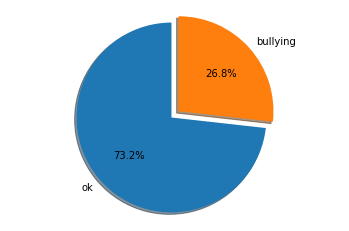

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
fig1, ax1 = plt.subplots()
ax1.pie(y.value_counts(), explode=(0, 0.1), labels=["ok","bullying"], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

In [10]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1,stratify = y)
x_test, x_validation, y_test, y_validation = train_test_split(x_test, y_test, test_size=0.5, random_state=1)

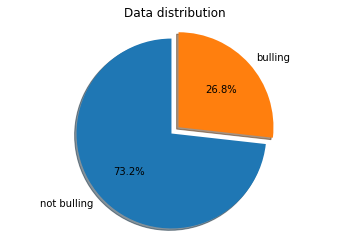

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
fig1, ax1 = plt.subplots()
ax1.pie(y_train.value_counts(), explode = [0,0.1], labels=["not bulling", "bulling"], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Data distribution")
plt.show()

In [12]:
label_0_weight = y.size / (y == 0).sum()
label_1_weight = y.size / (y == 1).sum()
label_1_weight,label_0_weight

(3.7353853049942103, 1.3655792104221005)

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

count_vect = CountVectorizer(min_df=0.001, lowercase=True,stop_words='english',preprocessor=preprocess_text) #max_features=1000
X_train_counts = count_vect.fit_transform(x_train)
x_train = pd.DataFrame(X_train_counts.toarray(), columns=count_vect.get_feature_names())

In [14]:
X_test_counts = count_vect.transform(x_test)
x_test = pd.DataFrame(X_test_counts.toarray(), columns=count_vect.get_feature_names())

In [15]:
X_validation_counts = count_vect.transform(x_validation)
x_validation = pd.DataFrame(X_validation_counts.toarray(), columns=count_vect.get_feature_names())

In [16]:
# from sklearn.utils import shuffle
# X_1 = pd.read_csv("../Data/log_1.csv", index_col=0)
# X_1 = shuffle(X_1)
# X_1 = X_1.loc[(X_1.sum(axis=1) != 0),:]
# X_1 = X_1.loc[(X_1.sum(axis=1) != 1),:]
# X_1 = X_1.loc[:,(X_1.sum(axis=0) != 0)]
# y = X_1["oh_label"]

In [17]:
from sklearn.preprocessing import StandardScaler
scaler_train = StandardScaler()
scaler_train.fit(x_train)
x_train = scaler_train.transform(x_train)
x_test = scaler_train.transform(x_test)
x_validation = scaler_train.transform(x_validation)

In [18]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# fig1, ax1 = plt.subplots()
# ax1.pie([70, 15, 15], explode = [0,0.1,0.1], labels=["train","test","validation"], autopct='%1.1f%%',
#         shadow=True, startangle=90)
# ax1.axis('equal') 
# plt.show()

In [19]:
# X_1.drop("oh_label",axis=1, inplace = True)
# X = X_1

In [20]:
label_0_weight = y_train.size / (y_train == 0).sum()
label_1_weight = y_train.size / (y_test == 1).sum()
label_1_weight,label_0_weight

(17.356806347632034, 1.3655872024970737)

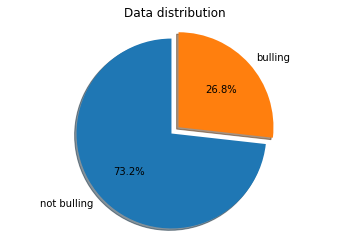

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
fig1, ax1 = plt.subplots()
ax1.pie(y_train.value_counts(), explode = [0,0.1], labels=["not bulling", "bulling"], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Data distribution")
plt.show()

In [22]:
# from sklearn.linear_model import SGDClassifier
# logmodel = SGDClassifier(max_iter=80,loss='log', class_weight= "balanced", random_state=42)
# logmodel.fit(x_train,y_train)
# predictions = logmodel.predict(x_test)
# print(classification_report(y_test,predictions,zero_division=0))
from collections import Counter
print(Counter(y_train))

Counter({0.0: 51260, 1.0: 18740})


In [23]:
# oversample implementation
# from imblearn.over_sampling import SMOTE

# from imblearn import under_sampling, over_sampling
# from imblearn.over_sampling import RandomOverSampler 
# oversample = RandomOverSampler(random_state=42,sampling_strategy=0.9)
# x_train, y_train = oversample.fit_resample(x_train, y_train)

In [24]:
label_0_weight = y_train.size / (y_train == 0).sum()
label_1_weight = y_train.size / (y_test == 1).sum()
label_1_weight,label_0_weight

(17.356806347632034, 1.3655872024970737)

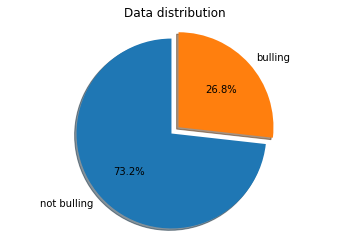

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
fig1, ax1 = plt.subplots()
ax1.pie(y_train.value_counts(), explode = [0,0.1], labels=["not bulling", "bulling"], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Data distribution")
plt.show()

In [26]:
from collections import Counter
print(Counter(y_train))

Counter({0.0: 51260, 1.0: 18740})


In [27]:
fx_train = np.concatenate((x_train,x_validation),axis=0) 
fy_train = np.concatenate((y_train, y_validation), axis=0)

In [24]:
import seaborn as sns
logistic = LogisticRegression(fx_train,fy_train, x_validation, y_validation.values,epoch=80,learning_rate=0.01,batch_size=100)
predictions = logistic.predict(x_test)
print(classification_report(y_test, predictions))

iteration 0: loss value is: 6.366030320058719
iteration 1: loss value is: 3.8952062709712685
iteration 2: loss value is: 2.8032195819653403
iteration 3: loss value is: 2.110885058389334
iteration 4: loss value is: 1.7525889395297423
iteration 5: loss value is: 1.5641546228942715
iteration 6: loss value is: 1.4523804037209223
iteration 7: loss value is: 1.3058009122077778
iteration 8: loss value is: 1.166264216105364
iteration 9: loss value is: 1.0363911355408055
iteration 10: loss value is: 0.9430107572786597
iteration 11: loss value is: 0.8559209132761809
iteration 12: loss value is: 0.7947994082119504
iteration 13: loss value is: 0.7449569774763694
iteration 14: loss value is: 0.7033389910096934
iteration 15: loss value is: 0.672762984614823
iteration 16: loss value is: 0.6558174953604802
iteration 17: loss value is: 0.6242823800089122
iteration 18: loss value is: 0.6175451449241397
iteration 19: loss value is: 0.5926970463425582
iteration 20: loss value is: 0.5915918836305479
iterat

In [75]:
clf_report = classification_report(y_test, predictions, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :-3].T, annot=True)
clf_report["accuracy"]

NameError: name 'predictions' is not defined

In [76]:
from sklearn.metrics import confusion_matrix
cc = confusion_matrix(y_validation, predictions, labels=[0, 1])
sns.heatmap(cc, annot=True, fmt="g", cmap='Blues')
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.ylabel("True label")

NameError: name 'predictions' is not defined

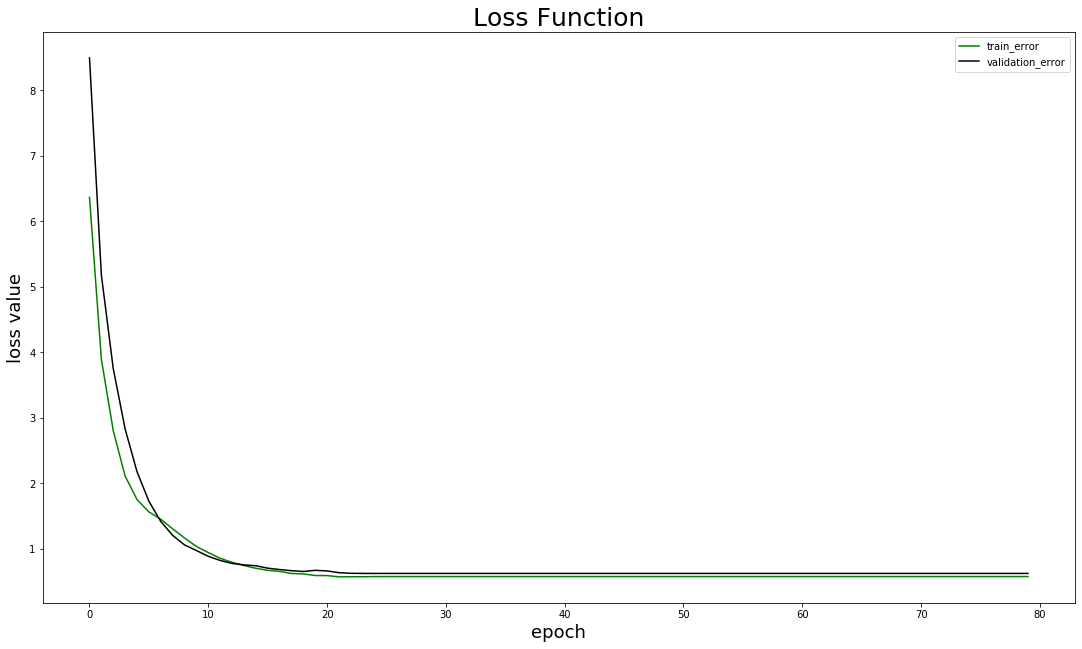

In [77]:
import matplotlib.pyplot as plt 
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
data_train = np.loadtxt("train_error.txt")
data_validation = np.loadtxt("validation_error.txt")
plt.plot(data_train,color='g',label='train_error')
plt.plot(data_validation,color='k',label='validation_error')
plt.xlabel("epoch", fontsize=18)
plt.ylabel("loss value",fontsize=18)
plt.title("Loss Function", fontsize = 25)
plt.legend()
plt.show()

In [78]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 


In [39]:
from sklearn.metrics import confusion_matrix

# MLP

In [28]:
y_test = y_test.values
y_test = y_test.reshape((y_test.size,1))
y_train = y_train.values
y_train = y_train.reshape((y_train.size,1))
y_validation = y_validation.values
y_validation = y_validation.reshape((y_validation.size,1))

In [29]:
learning_rate = 0.01
epoch=100
batch_size=200

In [35]:
def predict(sess,X_test,x_placeholder,y_final,thr=0.5):
    predictions = sess.run(tf.nn.sigmoid(sess.run(y_final, feed_dict={x_placeholder: X_test})))
    predictions[predictions >= thr] = 1
    predictions[predictions < thr] = 0
    print(classification_report(y_test, predictions))
    cc = confusion_matrix(y_test, predictions, labels=[0, 1])
    sns.heatmap(cc, annot=True, fmt="g", cmap='Blues')
    plt.xlabel("Predicted label")
    plt.title("Confusion Matrix")
    plt.ylabel("True label")
    plt.show()
    return predictions


def train(sess,final_y,y_train_variable,x_placeholder, dynamic_rate=True, weighted_loss=True):
    # x_train,y_train.values,x_test,y_test.values,x_validation, y_validation.values
    losses = []
    test_loss = []
    valid_loss = []
    learning_rate_tensor = tf.placeholder(tf.float64, shape=[])  # tensor for implement dynamic learning rate 
    lr = learning_rate
    w1_weight = (y_train == 1).sum()
    w0_weight = (y_train == 0).sum()
    if weighted_loss:
        loss = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(labels=y_train_variable, 
                            logits= tf.cast(final_y, tf.float64), 
                            pos_weight=tf.constant((w1_weight+w0_weight)/w1_weight, tf.float64)))
    else:
        loss = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(labels=y_train_variable, 
                            logits= tf.cast(final_y, tf.float64), 
                            pos_weight=tf.constant(0.5, tf.float64)))
    update = tf.train.AdamOptimizer(learning_rate_tensor).minimize(loss) 
    sess.run(tf.global_variables_initializer())
    rows_num = x_train.shape[0]
    for i in range(epoch):
        for counter_step in range(rows_num//batch_size):
            X_batch = x_train[counter_step * batch_size:min((counter_step + 1) * batch_size, rows_num)]
            Y_batch = y_train[counter_step * batch_size:min((counter_step + 1) * batch_size, rows_num)]
            sess.run(update, feed_dict={x_placeholder: X_batch, y_train_variable: Y_batch,learning_rate_tensor:lr})
        loss_value = sess.run(loss, feed_dict={x_placeholder: x_train, y_train_variable: y_train,learning_rate_tensor:lr})
        loss_value_test = sess.run(loss, feed_dict={x_placeholder:x_test, y_train_variable: y_test,learning_rate_tensor:lr})
        loss_value_validation = sess.run(loss, feed_dict={x_placeholder:x_validation, y_train_variable: y_validation,learning_rate_tensor:lr})
        print(f"iteration {i}: loss value is: {loss_value}")
        losses.append(loss_value)
        test_loss.append(loss_value_test)
        valid_loss.append(loss_value_validation)
        if dynamic_rate and losses[i] > losses[i-1]:        # check if the loss divergence
            print("=====change learning rate=========")
            lr = lr/10
    save_loss(losses, filename="MLP_train_error.txt")
    save_loss(test_loss, filename="MLP_test_error.txt")
    save_loss(valid_loss, filename="MLP_validation_error.txt")
    return losses,test_loss,valid_loss

In [27]:
config = tf.ConfigProto(device_count={"CPU": 8},inter_op_parallelism_threads=4,intra_op_parallelism_threads=4)
sess = tf.Session(config=config)
features = x_train.shape[1]
x_placeholder = tf.placeholder(tf.float64, [None, features])
y_train_variable = tf.placeholder(tf.float64, [None, 1])

W = tf.Variable(tf.random.uniform([features, 100],dtype=tf.float64))
b = tf.Variable(tf.random.uniform([100],dtype=tf.float64))
y = tf.add(tf.matmul(x_placeholder, W), b)

W1 = tf.Variable(tf.random.uniform([100, 60],dtype=tf.float64))
b1 = tf.Variable(tf.random.uniform([60],dtype=tf.float64))
y1 = tf.add(tf.matmul(y, W1), b1)

W2 = tf.Variable(tf.random.uniform([60,20],dtype=tf.float64))
b2 = tf.Variable(tf.random.uniform([20],dtype=tf.float64))
y2 = tf.add(tf.matmul(y1, W2), b2)

W3 = tf.Variable(tf.random.uniform([20,1],dtype=tf.float64))
b3 = tf.Variable(tf.random.uniform([1],dtype=tf.float64))
y_final = tf.add(tf.matmul(y2, W3), b3)

losses,test_loss,valid_loss = train(sess,y_final,y_train_variable,x_placeholder, dynamic_rate=False, weighted_loss=False)
predict(sess,x_test,x_placeholder,y_final)

ValueError: Cannot feed value of shape (200,) for Tensor Placeholder_1:0, which has shape (?, 1)

In [30]:
plt.plot(valid_loss[1:], label='validation loss', color='orange')
plt.plot(losses[1:], label='train loss', color='green')
plt.xlabel('epoch', size = 15)
plt.ylabel('loss', size = 15)
plt.title('')
plt.legend()
plt.savefig('../graphs/simple_mlp')

NameError: name 'valid_loss' is not defined

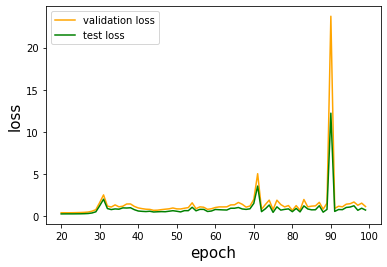

In [129]:
plt.plot(range(20,100), valid_loss[20:], label='validation loss', color='orange')
plt.plot(range(20,100), losses[20:], label='test loss', color='green')
plt.xlabel('epoch', size = 15)
plt.ylabel('loss', size = 15)
plt.title('')
plt.legend()
plt.savefig('../graphs/simple_mlp_no_start')

## lower learning rate

In [31]:
learning_rate = 0.001
epoch=50
batch_size=200

iteration 0: loss value is: 41998.511477536056
iteration 1: loss value is: 41.537845250745875
iteration 2: loss value is: 42.07585172911157
iteration 3: loss value is: 55.10199579066987
iteration 4: loss value is: 26.30318813594493
iteration 5: loss value is: 21.22192856821316
iteration 6: loss value is: 33.370940867763935
iteration 7: loss value is: 9.494015750294707
iteration 8: loss value is: 25.31392857529776
iteration 9: loss value is: 17.361294264283718
iteration 10: loss value is: 6.191425197633895
iteration 11: loss value is: 30.29539660841039
iteration 12: loss value is: 12.577200606769798
iteration 13: loss value is: 16.391734916403
iteration 14: loss value is: 12.99704913348217
iteration 15: loss value is: 14.023718655701979
iteration 16: loss value is: 95.69528795812434
iteration 17: loss value is: 7.668257486941702
iteration 18: loss value is: 4.686726881785234
iteration 19: loss value is: 23.906502251592695
iteration 20: loss value is: 11.824263780734027
iteration 21: los

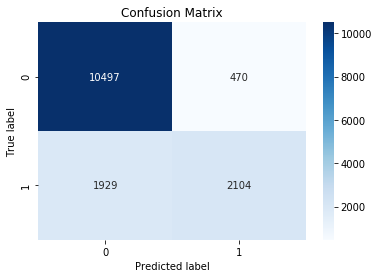

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [131]:
config = tf.ConfigProto(device_count={"CPU": 8},inter_op_parallelism_threads=4,intra_op_parallelism_threads=4)
sess = tf.Session(config=config)
features = x_train.shape[1]
x_placeholder = tf.placeholder(tf.float64, [None, features])
y_train_variable = tf.placeholder(tf.float64, [None, 1])

W = tf.Variable(tf.random.uniform([features, 100],dtype=tf.float64))
b = tf.Variable(tf.random.uniform([100],dtype=tf.float64))
y = tf.add(tf.matmul(x_placeholder, W), b)

W1 = tf.Variable(tf.random.uniform([100, 60],dtype=tf.float64))
b1 = tf.Variable(tf.random.uniform([60],dtype=tf.float64))
y1 = tf.add(tf.matmul(y, W1), b1)

W2 = tf.Variable(tf.random.uniform([60,20],dtype=tf.float64))
b2 = tf.Variable(tf.random.uniform([20],dtype=tf.float64))
y2 = tf.add(tf.matmul(y1, W2), b2)

W3 = tf.Variable(tf.random.uniform([20,1],dtype=tf.float64))
b3 = tf.Variable(tf.random.uniform([1],dtype=tf.float64))
y_final = tf.add(tf.matmul(y2, W3), b3)

losses2,test_loss2,valid_loss2 = train(sess,y_final,y_train_variable,x_placeholder, dynamic_rate=False, weighted_loss=False)
predict(sess,x_test,x_placeholder,y_final)

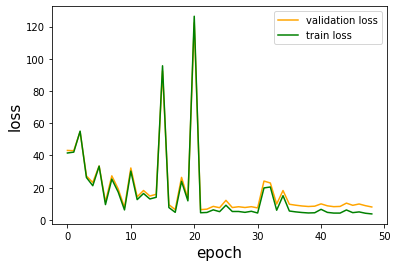

In [132]:
plt.plot(valid_loss2[1:], label='validation loss', color='orange')
plt.plot(losses2[1:], label='train loss', color='green')
plt.xlabel('epoch', size = 15)
plt.ylabel('loss', size = 15)
plt.title('')
plt.legend()
plt.savefig('../graphs/simple_mlp_low_rate')

## dynamic learning rate

In [32]:
learning_rate = 0.1
epoch=100
batch_size=200

iteration 0: loss value is: 1.613664425018821
iteration 1: loss value is: 0.5267091315391353
iteration 2: loss value is: 0.5982670828226175
=====change learning rate=========
iteration 3: loss value is: 0.28709151022678936
iteration 4: loss value is: 0.28285087090196365
iteration 5: loss value is: 0.29074206927487745
=====change learning rate=========
iteration 6: loss value is: 0.2665717574364881
iteration 7: loss value is: 0.2679216618411771
=====change learning rate=========
iteration 8: loss value is: 0.25932803011320826
iteration 9: loss value is: 0.25892915147036816
iteration 10: loss value is: 0.2588931381541863
iteration 11: loss value is: 0.25898438746163466
=====change learning rate=========
iteration 12: loss value is: 0.2583735331334564
iteration 13: loss value is: 0.2581681640900764
iteration 14: loss value is: 0.2580721944082049
iteration 15: loss value is: 0.2580206415917958
iteration 16: loss value is: 0.25799121025873206
iteration 17: loss value is: 0.25797549434867867

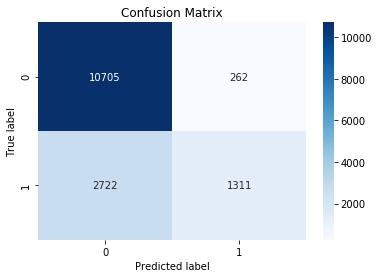

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [137]:
config = tf.ConfigProto(device_count={"CPU": 8},inter_op_parallelism_threads=4,intra_op_parallelism_threads=4)
sess = tf.Session(config=config)
features = x_train.shape[1]
x_placeholder = tf.placeholder(tf.float64, [None, features])
y_train_variable = tf.placeholder(tf.float64, [None, 1])

W = tf.Variable(tf.random.uniform([features, 100],dtype=tf.float64))
b = tf.Variable(tf.random.uniform([100],dtype=tf.float64))
y = tf.add(tf.matmul(x_placeholder, W), b)

W1 = tf.Variable(tf.random.uniform([100, 60],dtype=tf.float64))
b1 = tf.Variable(tf.random.uniform([60],dtype=tf.float64))
y1 = tf.add(tf.matmul(y, W1), b1)

W2 = tf.Variable(tf.random.uniform([60,20],dtype=tf.float64))
b2 = tf.Variable(tf.random.uniform([20],dtype=tf.float64))
y2 = tf.add(tf.matmul(y1, W2), b2)

W3 = tf.Variable(tf.random.uniform([20,1],dtype=tf.float64))
b3 = tf.Variable(tf.random.uniform([1],dtype=tf.float64))
y_final = tf.add(tf.matmul(y2, W3), b3)

losses3,test_loss3,valid_loss3 = train(sess,y_final,y_train_variable,x_placeholder, dynamic_rate=True, weighted_loss=False)
predict(sess,x_test,x_placeholder,y_final)

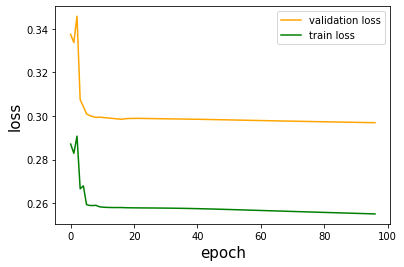

In [140]:
plt.plot(valid_loss3[3:], label='validation loss', color='orange')
plt.plot(losses3[3:], label='train loss', color='green')
plt.xlabel('epoch', size = 15)
plt.ylabel('loss', size = 15)
plt.title('')
plt.legend()
plt.savefig('../graphs/dynamic_rate')

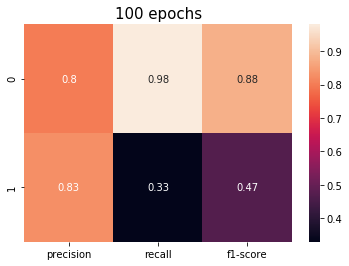

In [3]:
mat = [[0.80, 0.98,0.88],
        [0.83, 0.33, 0.47]]

sns.heatmap(mat, annot=True)
plt.xticks([0.5,1.5,2.5],['precision', 'recall', 'f1-score'])
# plt.xticks([])
plt.title('100 epochs', size=15)
plt.savefig('../graphs/cla_rep_dynamic_rate')

## bigger network, more training

In [88]:
learning_rate = 0.1
epoch=500
batch_size=200

In [ ]:
config = tf.ConfigProto(device_count={"CPU": 8},inter_op_parallelism_threads=4,intra_op_parallelism_threads=4)
sess = tf.Session(config=config)
features = x_train.shape[1]
x_placeholder = tf.placeholder(tf.float64, [None, features])
y_train_variable = tf.placeholder(tf.float64, [None, 1])

W = tf.Variable(tf.random.uniform([features, 1000],dtype=tf.float64))
b = tf.Variable(tf.random.uniform([1000],dtype=tf.float64))
y = tf.add(tf.matmul(x_placeholder, W), b)

W1 = tf.Variable(tf.random.uniform([1000, 600],dtype=tf.float64))
b1 = tf.Variable(tf.random.uniform([600],dtype=tf.float64))
y1 = tf.add(tf.matmul(y, W1), b1)

W2 = tf.Variable(tf.random.uniform([600,200],dtype=tf.float64))
b2 = tf.Variable(tf.random.uniform([200],dtype=tf.float64))
y2 = tf.add(tf.matmul(y1, W2), b2)

W3 = tf.Variable(tf.random.uniform([200,1],dtype=tf.float64))
b3 = tf.Variable(tf.random.uniform([1],dtype=tf.float64))
y_final = tf.add(tf.matmul(y2, W3), b3)

losses4,test_loss4,valid_loss4 = train(sess,y_final,y_train_variable,x_placeholder, dynamic_rate=True, weighted_loss=False)
predict(sess,x_test,x_placeholder,y_final)

iteration 0: loss value is: 41.831565773110746
iteration 1: loss value is: 38.32197959876571
iteration 2: loss value is: 49.68526844996158
=====change learning rate=========
iteration 3: loss value is: 26.30153156595335
iteration 4: loss value is: 20.663431545854177
iteration 5: loss value is: 16.250001506067534
iteration 6: loss value is: 14.98075376544389
iteration 7: loss value is: 13.871569497691029
iteration 8: loss value is: 13.490840929417491
iteration 9: loss value is: 14.192221919484075
=====change learning rate=========
iteration 10: loss value is: 8.489513899641377
iteration 11: loss value is: 7.891366341034325
iteration 12: loss value is: 7.509866377718078
iteration 13: loss value is: 6.936692974293391
iteration 14: loss value is: 6.956645195584908
=====change learning rate=========
iteration 15: loss value is: 6.083487154511876
iteration 16: loss value is: 5.944170373021003
iteration 17: loss value is: 5.984187317804058
=====change learning rate=========


In [ ]:
plt.plot(valid_loss4, label='validation loss', color='orange')
plt.plot(losses4, label='train loss', color='green')
plt.xlabel('epoch', size = 15)
plt.ylabel('loss', size = 15)
plt.title('big network, 1000 epochs')
plt.legend()
plt.savefig('../graphs/dynamic_rate_big_network_more_epochs')

## over sample

In [34]:
from imblearn.over_sampling import RandomOverSampler 
oversample = RandomOverSampler(random_state=42,sampling_strategy=0.9)
x_train, y_train = oversample.fit_resample(x_train, y_train)

In [37]:
y_train.value_counts()[1] / y_train.value_counts()[0] 

0.9

In [42]:
y_test = y_test.values
y_test = y_test.reshape((y_test.size,1))
y_train = y_train.values
y_train = y_train.reshape((y_train.size,1))
y_validation = y_validation.values
y_validation = y_validation.reshape((y_validation.size,1))

In [43]:
learning_rate = 0.1
epoch=100
batch_size=200

In [44]:
config = tf.ConfigProto(device_count={"CPU": 8},inter_op_parallelism_threads=4,intra_op_parallelism_threads=4)
sess = tf.Session(config=config)
features = x_train.shape[1]
x_placeholder = tf.placeholder(tf.float64, [None, features])
y_train_variable = tf.placeholder(tf.float64, [None, 1])

W = tf.Variable(tf.random.uniform([features, 100],dtype=tf.float64))
b = tf.Variable(tf.random.uniform([100],dtype=tf.float64))
y = tf.add(tf.matmul(x_placeholder, W), b)

W1 = tf.Variable(tf.random.uniform([100, 60],dtype=tf.float64))
b1 = tf.Variable(tf.random.uniform([60],dtype=tf.float64))
y1 = tf.add(tf.matmul(y, W1), b1)

W2 = tf.Variable(tf.random.uniform([60,20],dtype=tf.float64))
b2 = tf.Variable(tf.random.uniform([20],dtype=tf.float64))
y2 = tf.add(tf.matmul(y1, W2), b2)

W3 = tf.Variable(tf.random.uniform([20,1],dtype=tf.float64))
b3 = tf.Variable(tf.random.uniform([1],dtype=tf.float64))
y_final = tf.add(tf.matmul(y2, W3), b3)

losses5,test_loss5,valid_loss5 = train(sess,y_final,y_train_variable,x_placeholder, dynamic_rate=True, weighted_loss=False)
predict(sess,x_test,x_placeholder,y_final)

iteration 0: loss value is: 30.12705009640762
iteration 1: loss value is: 37.97175092789121
=====change learning rate=========
iteration 2: loss value is: 7.274166848873626
iteration 3: loss value is: 5.611004351544923
iteration 4: loss value is: 6.263548096346961
=====change learning rate=========
iteration 5: loss value is: 1.9055115381893504
iteration 6: loss value is: 2.0006839641714245
=====change learning rate=========
iteration 7: loss value is: 0.7630382361345962
iteration 8: loss value is: 0.8382496750263847
=====change learning rate=========
iteration 9: loss value is: 0.43519903778072433
iteration 10: loss value is: 0.4325744865603938
iteration 11: loss value is: 0.452435651544711
=====change learning rate=========
iteration 12: loss value is: 0.36609334831321866
iteration 13: loss value is: 0.349933809209756
iteration 14: loss value is: 0.3456598190085504
iteration 15: loss value is: 0.3455293432854235
iteration 16: loss value is: 0.34710683425180877
=====change learning ra

NameError: name 'confusion_matrix' is not defined

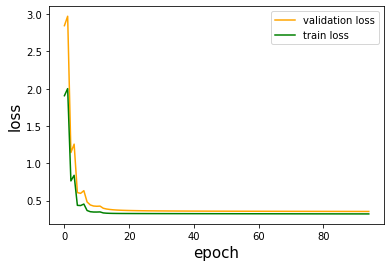

In [50]:
plt.plot(valid_loss5[5:], label='validation loss', color='orange')
plt.plot(losses5[5:], label='train loss', color='green')
plt.xlabel('epoch', size = 15)
plt.ylabel('loss', size = 15)
plt.title('')
plt.legend()
plt.savefig('../graphs/over_sampeling')

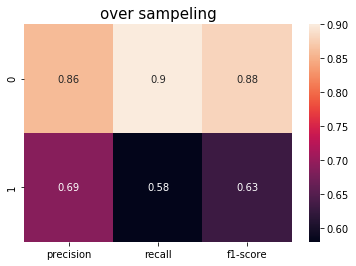

In [51]:
mat = [[0.86, 0.90,0.88],
        [0.69, 0.58, 0.63]]

sns.heatmap(mat, annot=True)
plt.xticks([0.5,1.5,2.5],['precision', 'recall', 'f1-score'])
plt.title('over sampeling', size=15)
plt.savefig('../graphs/cla_rep_over_sampeling')

## weighted loss

In [31]:
learning_rate = 0.1
epoch=100
batch_size=200

iteration 0: loss value is: 42.999705002401065
iteration 1: loss value is: 3.3110151877281555
iteration 2: loss value is: 2.6809482094045
iteration 3: loss value is: 4.35929587078761
=====change learning rate=========
iteration 4: loss value is: 0.996490299523206
iteration 5: loss value is: 1.0409285507326405
=====change learning rate=========
iteration 6: loss value is: 0.810626019982058
iteration 7: loss value is: 0.8117193391299933
=====change learning rate=========
iteration 8: loss value is: 0.751557970034824
iteration 9: loss value is: 0.7457766537968828
iteration 10: loss value is: 0.7455080912272084
iteration 11: loss value is: 0.7470325690043783
=====change learning rate=========
iteration 12: loss value is: 0.7385735099426955
iteration 13: loss value is: 0.7351924405763105
iteration 14: loss value is: 0.733862614315498
iteration 15: loss value is: 0.7333679874767277
iteration 16: loss value is: 0.7332645752373572
iteration 17: loss value is: 0.7333982778596707
=====change lea

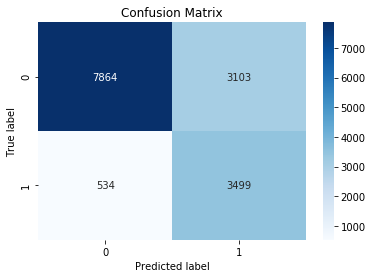

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [0.],
       [0.]])

In [85]:
config = tf.ConfigProto(device_count={"CPU": 8},inter_op_parallelism_threads=4,intra_op_parallelism_threads=4)
sess = tf.Session(config=config)
features = x_train.shape[1]
x_placeholder = tf.placeholder(tf.float64, [None, features])
y_train_variable = tf.placeholder(tf.float64, [None, 1])

W = tf.Variable(tf.random.uniform([features, 100],dtype=tf.float64))
b = tf.Variable(tf.random.uniform([100],dtype=tf.float64))
y = tf.add(tf.matmul(x_placeholder, W), b)

W1 = tf.Variable(tf.random.uniform([100, 60],dtype=tf.float64))
b1 = tf.Variable(tf.random.uniform([60],dtype=tf.float64))
y1 = tf.add(tf.matmul(y, W1), b1)

W2 = tf.Variable(tf.random.uniform([60,20],dtype=tf.float64))
b2 = tf.Variable(tf.random.uniform([20],dtype=tf.float64))
y2 = tf.add(tf.matmul(y1, W2), b2)

W3 = tf.Variable(tf.random.uniform([20,1],dtype=tf.float64))
b3 = tf.Variable(tf.random.uniform([1],dtype=tf.float64))
y_final = tf.add(tf.matmul(y2, W3), b3)

losses6,test_loss6,valid_loss6 = train(sess,y_final,y_train_variable,x_placeholder, dynamic_rate=True, weighted_loss=True)
predict(sess,x_test,x_placeholder,y_final)

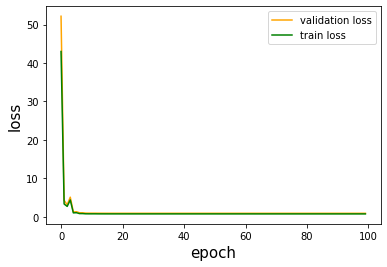

In [86]:
plt.plot(valid_loss6, label='validation loss', color='orange')
plt.plot(losses6, label='train loss', color='green')
plt.xlabel('epoch', size = 15)
plt.ylabel('loss', size = 15)
plt.title('')
plt.legend()
plt.savefig('../graphs/weighted_loss')

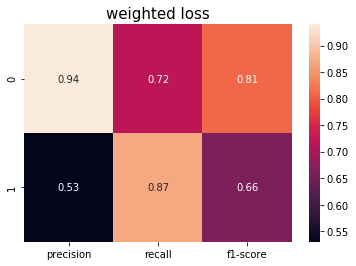

In [7]:
mat = [[0.94, 0.72,0.81],
        [0.53, 0.87, 0.66]]

sns.heatmap(mat, annot=True)
plt.xticks([0.5,1.5,2.5],['precision', 'recall', 'f1-score'])
plt.title('weighted loss', size=15)
plt.savefig('../graphs/cla_rep_weighed_loss')

## finale train

In [36]:
x_train = np.concatenate((x_train,x_validation),axis=0) 
y_train = np.concatenate((y_train, y_validation), axis=0)

In [37]:
learning_rate = 0.1
epoch=100
batch_size=200

iteration 0: loss value is: 38.33782191524188
iteration 1: loss value is: 2.9448597411106427
iteration 2: loss value is: 1.818516833555268
iteration 3: loss value is: 2.7794412278169784
=====change learning rate=========
iteration 4: loss value is: 0.9915223874376412
iteration 5: loss value is: 1.0037600143222698
=====change learning rate=========
iteration 6: loss value is: 0.8168075874098741
iteration 7: loss value is: 0.8203675705406952
=====change learning rate=========
iteration 8: loss value is: 0.7526875029890557
iteration 9: loss value is: 0.7495827282399184
iteration 10: loss value is: 0.7514125458875803
=====change learning rate=========
iteration 11: loss value is: 0.7454057861396441
iteration 12: loss value is: 0.7430286128139285
iteration 13: loss value is: 0.7420171174694008
iteration 14: loss value is: 0.7416228897438012
iteration 15: loss value is: 0.7415613568207835
iteration 16: loss value is: 0.7417189272930367
=====change learning rate=========
iteration 17: loss va

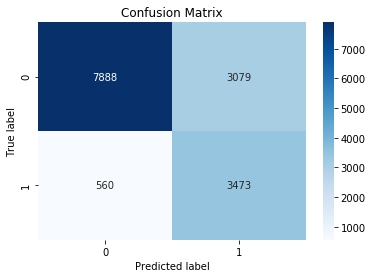

array([[1.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [40]:
config = tf.ConfigProto(device_count={"CPU": 8},inter_op_parallelism_threads=4,intra_op_parallelism_threads=4)
sess = tf.Session(config=config)
features = x_train.shape[1]
x_placeholder = tf.placeholder(tf.float64, [None, features])
y_train_variable = tf.placeholder(tf.float64, [None, 1])

W = tf.Variable(tf.random.uniform([features, 100],dtype=tf.float64))
b = tf.Variable(tf.random.uniform([100],dtype=tf.float64))
y = tf.add(tf.matmul(x_placeholder, W), b)

W1 = tf.Variable(tf.random.uniform([100, 60],dtype=tf.float64))
b1 = tf.Variable(tf.random.uniform([60],dtype=tf.float64))
y1 = tf.add(tf.matmul(y, W1), b1)

W2 = tf.Variable(tf.random.uniform([60,20],dtype=tf.float64))
b2 = tf.Variable(tf.random.uniform([20],dtype=tf.float64))
y2 = tf.add(tf.matmul(y1, W2), b2)

W3 = tf.Variable(tf.random.uniform([20,1],dtype=tf.float64))
b3 = tf.Variable(tf.random.uniform([1],dtype=tf.float64))
y_final = tf.add(tf.matmul(y2, W3), b3)

losses7,test_loss7,valid_loss7 = train(sess,y_final,y_train_variable,x_placeholder, dynamic_rate=True, weighted_loss=True)
predict(sess,x_test,x_placeholder,y_final)

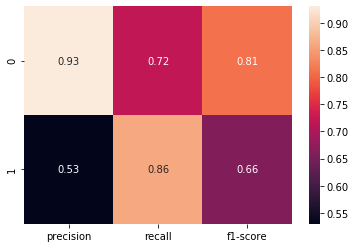

In [44]:
mat = [[0.93, 0.72,0.81],
        [0.53, 0.86, 0.66]]

sns.heatmap(mat, annot=True)
plt.xticks([0.5,1.5,2.5],['precision', 'recall', 'f1-score'])
plt.title('', size=15)
plt.savefig('../Reports/graphs/cla_report_finale_mlp')

# sklearn mlp

In [39]:
# x_train,y_train.values,x_test,y_test.values,x_validation, y_validation.values
x_train.shape

(70000, 3274)

In [40]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

In [24]:
def mlp_pipeline(clf):
    clf.fit(x_train, y_train.values)
    predictions = clf.predict(x_validation)
    print(classification_report(y_validation.values, predictions))
    cc = confusion_matrix(y_validation, predictions, labels=[0, 1])
    sns.heatmap(cc, annot=True, fmt="g", cmap='Blues')
    plt.xlabel("Predicted label")
    plt.title("Confusion Matrix")
    plt.ylabel("True label")
    plt.show()

In [31]:
clf1 = MLPClassifier(random_state=1,learning_rate_init=0.01,batch_size=200,activation="relu",
                    hidden_layer_sizes=(1000,500,100),solver='adam',max_iter=100,verbose=True)

Iteration 1, loss = 0.49186077
Iteration 2, loss = 0.33885007
Iteration 3, loss = 0.28019483
Iteration 4, loss = 0.25849795
Iteration 5, loss = 0.26839807
Iteration 6, loss = 0.27504068
Iteration 7, loss = 0.30506439
Iteration 8, loss = 0.30173568
Iteration 9, loss = 0.31940272
Iteration 10, loss = 0.31854720
Iteration 11, loss = 0.38491808
Iteration 12, loss = 0.33769531
Iteration 13, loss = 0.33362320
Iteration 14, loss = 0.31822858
Iteration 15, loss = 0.51952984
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
              precision    recall  f1-score   support

         0.0       0.74      1.00      0.85     11002
         1.0       0.93      0.05      0.10      3998

    accuracy                           0.75     15000
   macro avg       0.84      0.53      0.48     15000
weighted avg       0.79      0.75      0.65     15000



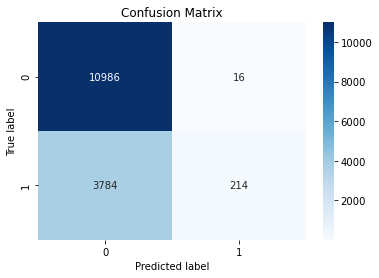

In [30]:
mlp_pipeline(clf1)

In [34]:
losses = [0.49186077,0.33885007,0.28019483,0.25849795,0.26839807,0.27504068,0.30506439,0.30173568,0.31940272,0.31854720,0.38491808,0.33769531,0.33362320,0.31822858,0.51952984]

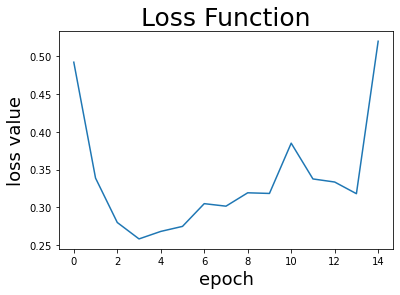

In [36]:
plt.xlabel("epoch", fontsize=18)
plt.ylabel("loss value",fontsize=18)
plt.title("Loss Function", fontsize = 25)
plt.plot(losses)

In [26]:
clf4 = MLPClassifier(random_state=1,learning_rate_init=0.01,batch_size=200,activation="relu",
                    hidden_layer_sizes=(500,100),solver='adam',max_iter=100,verbose=True,learning_rate="adaptive")

Iteration 1, loss = 0.45095640
Iteration 2, loss = 0.32264742
Iteration 3, loss = 0.28246963
Iteration 4, loss = 0.25420961
Iteration 5, loss = 0.22714410
Iteration 6, loss = 0.21668556
Iteration 7, loss = 0.20236626
Iteration 8, loss = 0.19336735
Iteration 9, loss = 0.25130103
Iteration 10, loss = 0.26460682
Iteration 11, loss = 0.24749870
Iteration 12, loss = 0.21447996
Iteration 13, loss = 0.18785226
Iteration 14, loss = 0.17101251
Iteration 15, loss = 0.16755544
Iteration 16, loss = 0.16009359
Iteration 17, loss = 0.15640802
Iteration 18, loss = 0.15560491
Iteration 19, loss = 0.19960598
Iteration 20, loss = 0.21710439
Iteration 21, loss = 0.21891133
Iteration 22, loss = 0.23245732
Iteration 23, loss = 0.22602136
Iteration 24, loss = 0.22045110
Iteration 25, loss = 0.21191584
Iteration 26, loss = 0.21565911
Iteration 27, loss = 0.20165730
Iteration 28, loss = 0.19929792
Iteration 29, loss = 0.20204708
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. S

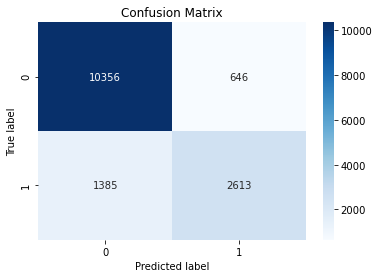

In [27]:
mlp_pipeline(clf4)

In [29]:
# oversample implementation
from imblearn.over_sampling import SMOTE

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import RandomOverSampler 
oversample = RandomOverSampler(random_state=42,sampling_strategy=0.9)
x_train, y_train = oversample.fit_resample(x_train, y_train)

Iteration 1, loss = 0.45326188
Iteration 2, loss = 0.31300272
Iteration 3, loss = 0.25596418
Iteration 4, loss = 0.23238772
Iteration 5, loss = 0.21124959
Iteration 6, loss = 0.20251263
Iteration 7, loss = 0.20501424
Iteration 8, loss = 0.18075419
Iteration 9, loss = 0.17299856
Iteration 10, loss = 0.19146705
Iteration 11, loss = 0.26030485
Iteration 12, loss = 0.20467961
Iteration 13, loss = 0.18405184
Iteration 14, loss = 0.16926886
Iteration 15, loss = 0.16930555
Iteration 16, loss = 0.16689334
Iteration 17, loss = 0.16862678
Iteration 18, loss = 0.16211799
Iteration 19, loss = 0.21781083
Iteration 20, loss = 0.15842945
Iteration 21, loss = 0.14819519
Iteration 22, loss = 0.14282927
Iteration 23, loss = 0.13915942
Iteration 24, loss = 0.14382271
Iteration 25, loss = 0.13579911
Iteration 26, loss = 0.13237113
Iteration 27, loss = 0.17389022
Iteration 28, loss = 0.22270478
Iteration 29, loss = 0.24749279
Iteration 30, loss = 0.22262463
Iteration 31, loss = 0.18442084
Iteration 32, los

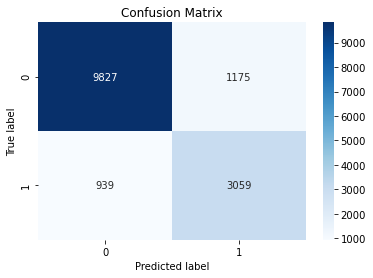

In [31]:
mlp_pipeline(clf4)

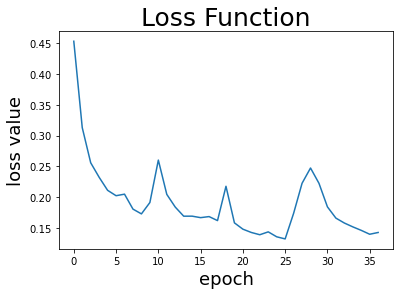

In [35]:
plt.xlabel("epoch", fontsize=18)
plt.ylabel("loss value",fontsize=18)
plt.title("Loss Function", fontsize = 25)
plt.plot(clf4.loss_curve_)

In [37]:
clf2 = MLPClassifier(random_state=1,learning_rate_init=0.01,batch_size=200,activation="relu",
                    hidden_layer_sizes=(1000,500,100,50),solver='adam',max_iter=10000,verbose=True)

Iteration 1, loss = 0.48971795
Iteration 2, loss = 0.30826715
Iteration 3, loss = 0.24823736
Iteration 4, loss = 0.20594403
Iteration 5, loss = 0.19883064
Iteration 6, loss = 0.18704543
Iteration 7, loss = 0.19016211
Iteration 8, loss = 0.17450848
Iteration 9, loss = 0.16860291
Iteration 10, loss = 0.18233587
Iteration 11, loss = 0.19114677
Iteration 12, loss = 0.17953748
Iteration 13, loss = 0.17655120
Iteration 14, loss = 0.19815418
Iteration 15, loss = 0.22945104
Iteration 16, loss = 0.26846874
Iteration 17, loss = 0.29312804
Iteration 18, loss = 0.22359564
Iteration 19, loss = 0.19047879
Iteration 20, loss = 0.18133550
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91     11002
         1.0       0.75      0.76      0.76      3998

    accuracy                           0.87     15000
   macro avg       0.83      0.83      0.83     15000
weighte

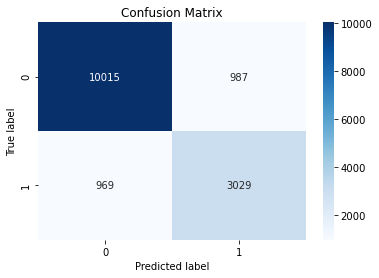

In [38]:
mlp_pipeline(clf2)

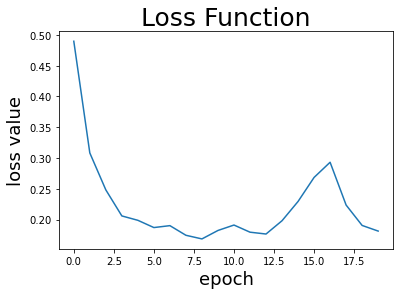

In [39]:
plt.xlabel("epoch", fontsize=18)
plt.ylabel("loss value",fontsize=18)
plt.title("Loss Function", fontsize = 25)
plt.plot(clf2.loss_curve_)

In [ ]:
clf3 = MLPClassifier(random_state=1,learning_rate_init=0.01,batch_size=200,activation="relu",
                    hidden_layer_sizes=(1000,500,100),solver='sgd',max_iter=10000,verbose=True)